# Python Assignment 4
### MCT4001 - Kristian Wentzel


## 1. Setting up

In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time

#importing signal processing package from scipy
from scipy import signal

# Setting global sampling rate
sr = 48000

In [2]:
# Defining functions from Stefano that will be used for this assignment

def mySineSynth(freq, dur_ms, amp=1, pha=0, sr=48000):

    t = np.arange(0,dur_ms/1000,1/sr)
    s = amp*np.sin(2*np.pi*freq*t+pha)
    
    return s

def myPlotStem(signal,title):
    plt.figure(figsize=(10, 3))
    plt.stem(signal, use_line_collection=True)
    plt.grid(True)
    plt.xticks(range(0,signal.size))
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()

def myPlotLine(signal,title):
    plt.figure(figsize=(10, 3))
    plt.plot(signal)
    plt.grid(True)
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()
    
def mySpectrogram(s,sr,title):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title)
    plt.show()

def myWaveform(s,sr,title):
    plt.figure(figsize=(10, 3))
    librosa.display.waveplot(s, sr=sr)
    plt.title(title)
    plt.show()

def myFiltResponse(b,a,sr):
    w, h = scipy.signal.freqz(b,a)
    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')
    ax1.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Normalized Frequency')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w/math.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

In [3]:
# Defining a function to convert from hertz to normalized frequency
def hzNorm(hz, sr=48000):
    norm = hz / (sr / 2)
    if hz > sr / 2:
        print(hz, "Hz is above the Nyquist frequency for samplerate:\t", sr)
    else:
        return norm

### 1.1 Defining functions for synthesizing sounds

In [4]:
# Defining a sine-LFO
def myLFO(hz, s=1, amp=0.8, sr=48000):
    lfo = mySineSynth(hz, s*1000, amp, sr=sr)
    
    return lfo


# Defining a PWM-Squaresynth function
def myPWM(hz, lfo_hz, s=1, sr=48000):
    t = np.linspace(0, 1, sr*s, endpoint=False)
    lfo = myLFO(lfo_hz, s, sr=sr)
    pwm = signal.square(2 * np.pi * hz * t, duty=(lfo + 1)/2)
    
    return pwm


# Defining a Sawsynth function
def mySaw(hz, s=1, sr=48000):
    t = np.linspace(0, 1, sr*s)
    saw = signal.sawtooth(2 * np.pi * hz * t)
    
    return saw


# Defining a Chirp function
def myChirp(hz_from, hz_to, s=5, sr=48000):
    t = np.arange(0, int(s*sr)) / sr
    chirp = signal.chirp(t, f0=hz_from, f1=hz_to, t1=s, method='linear',
          vertex_zero=False)

    return chirp


---

# Filter designs:

## 2 Low-Pass

I will design two types of Low-Pass filters with cutoff set to 2kHz

#### Generating PWM-Squarewaves for testing of filters

1 sec of 1kHz, 2kHz and 4kHz PWM-squarewaves with LFO set to 1 hz. (In effect sounding like 2Hz, since the LFO is bidirectional and the PWM effect sounds the same on both the +0.8 and -0.8 peaks of the wave.)

In [5]:
pwm1000 = myPWM(1000, 1, sr=sr)
pwm2000 = myPWM(2000, 1, sr=sr)
pwm4000 = myPWM(4000, 1, sr=sr)

### 2.1 Designing a Low-Pass FIR filter

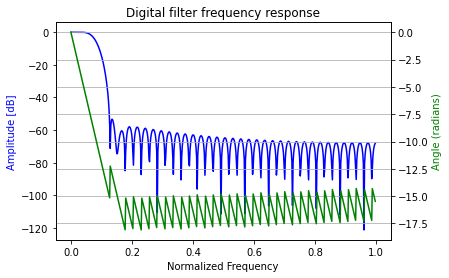

In [6]:
# firwin filter
# 77 taps, 2000Hz cutoff

numtaps = 77
f = hzNorm(2000)

firlp = signal.firwin(numtaps, f)

myFiltResponse(firlp, 1, sr)

### 2.1.1 Testing the FIR LoPass filter

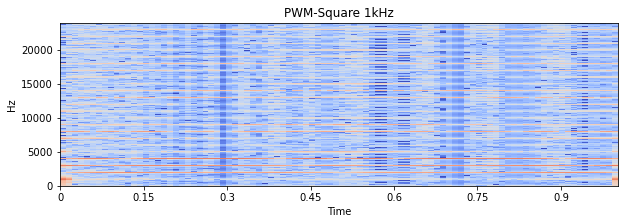

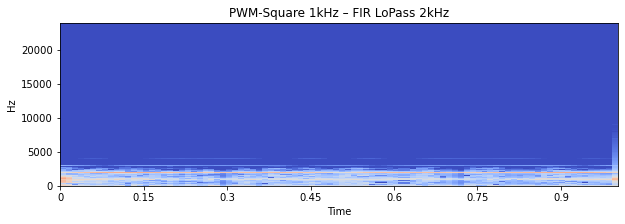

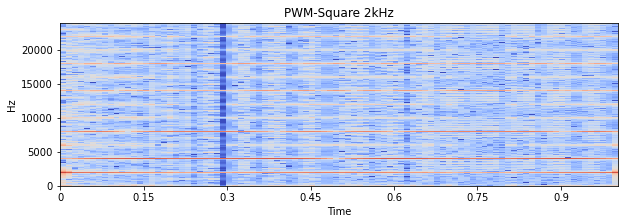

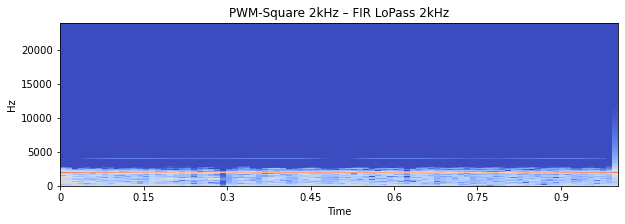

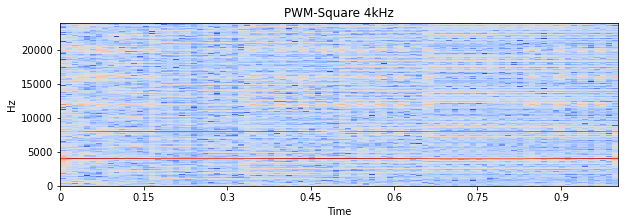

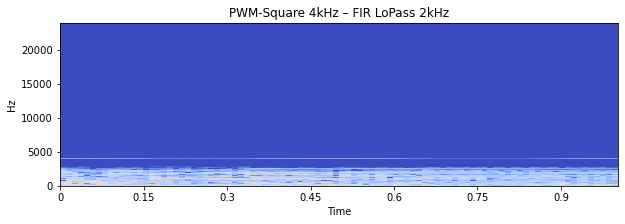

In [7]:
# Filtering the 1kHz PWM-squarewave
firlp_pwm1000 = signal.lfilter(firlp, 1, pwm1000)
mySpectrogram(pwm1000, sr, 'PWM-Square 1kHz')
mySpectrogram(firlp_pwm1000, sr, 'PWM-Square 1kHz – FIR LoPass 2kHz')

# Filtering the 2kHz PWM-squarewave
firlp_pwm2000 = signal.lfilter(firlp, 1, pwm2000)
mySpectrogram(pwm2000, sr, 'PWM-Square 2kHz')
mySpectrogram(firlp_pwm2000, sr, 'PWM-Square 2kHz – FIR LoPass 2kHz')

# Filtering the 4kHz PWM-squarewave
firlp_pwm4000 = signal.lfilter(firlp, 1, pwm4000)
mySpectrogram(pwm4000, sr, 'PWM-Square 4kHz')
mySpectrogram(firlp_pwm4000, sr, 'PWM-Square 4kHz – FIR LoPass 2kHz')

### 2.1.2 Playback of FIR filtered PWM-Squarewave

- The filtered 1kHz gets "tamed", as the harmonics are starting to get filtered.
- The filtered 2kHz is even more dulled, since the fundamental is just where the passband starts. The PWM-effect is barely audible.
- The filtered 4kHz sounds completely filtered.

We can hear some artifacts in every sound example, which also are visible in the spectrogram – because of the squarewaves upper harmonics being aliased. This is explained in the documentation of `scipy.signal.wave`:

"Note that this is not band-limited. It produces an infinite number of harmonics, which are aliased back and forth across the frequency spectrum."

In [8]:
sd.play(pwm1000/np.max(pwm1000),sr)
sd.wait()
sd.play(firlp_pwm1000/np.max(firlp_pwm1000),sr)
sd.wait()
sd.play(pwm2000/np.max(pwm2000),sr)
sd.wait()
sd.play(firlp_pwm2000/np.max(firlp_pwm2000),sr)
sd.wait()
sd.play(pwm4000/np.max(pwm4000),sr)
sd.wait()
sd.play(firlp_pwm4000/np.max(firlp_pwm4000),sr)
sd.wait()

### 2.2 Designing a Low-Pass IIR filter

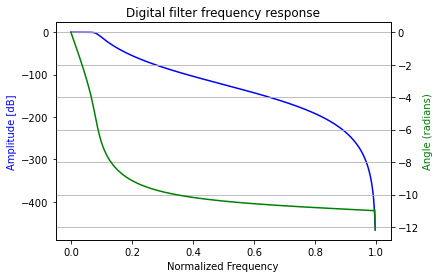

In [9]:
# butterworth filter
# 7 taps, 2000Hz cutoff

order = 7
fc = hzNorm(2000) # cutoff normalized frequency

iirlp_b, iirlp_a = signal.butter(order, fc, 'low', analog=False)

# displaying response
myFiltResponse(iirlp_b,iirlp_a,sr)

### 2.2.1 Testing the IIR LoPass filter

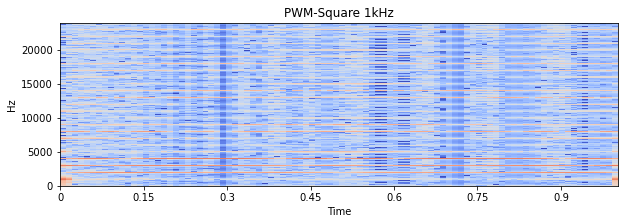

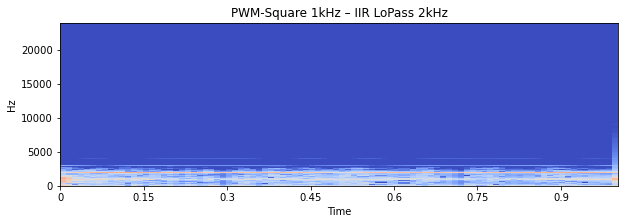

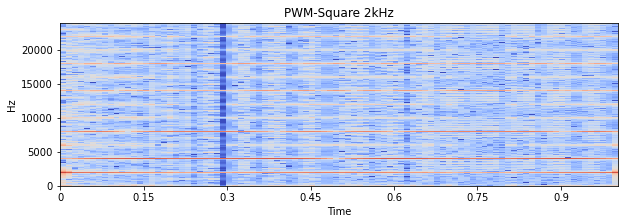

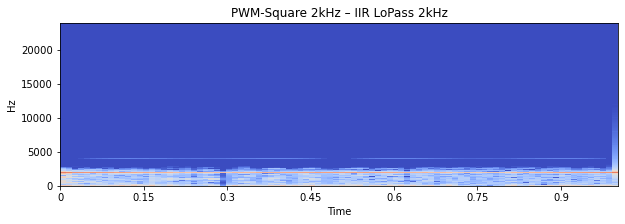

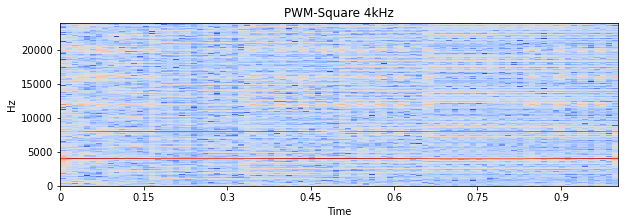

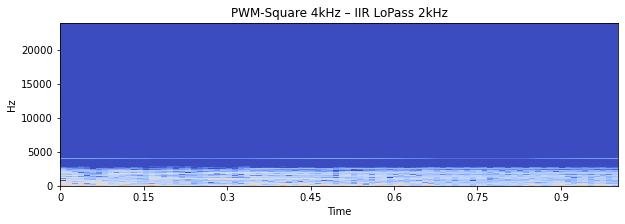

In [10]:
# Filtering the 1kHz squarewave
iirlp_pwm1000 = signal.lfilter(iirlp_b, iirlp_a, pwm1000)
mySpectrogram(pwm1000, sr, 'PWM-Square 1kHz')
mySpectrogram(firlp_pwm1000, sr, 'PWM-Square 1kHz – IIR LoPass 2kHz')

# Filtering the 2kHz squarewave
iirlp_pwm2000 = signal.lfilter(iirlp_b, iirlp_a, pwm2000)
mySpectrogram(pwm2000, sr, 'PWM-Square 2kHz')
mySpectrogram(firlp_pwm2000, sr, 'PWM-Square 2kHz – IIR LoPass 2kHz')

# Filtering the 4kHz squarewave
iirlp_pwm4000 = signal.lfilter(iirlp_b, iirlp_a, pwm4000)
mySpectrogram(pwm4000, sr, 'PWM-Square 4kHz')
mySpectrogram(firlp_pwm4000, sr, 'PWM-Square 4kHz – IIR LoPass 2kHz')

### 2.2.2 Playback of IIR filtered PWM-Squarewave

- The response sounds quite similar to that of the FIR filter.

The biggest difference I can hear, and also see on the spectrogram, is that the IIR is not completely filtering away the 4kHz square. This might suggest that the FIR filter is "steeper" in it's transition band.

In [11]:
sd.play(pwm1000/np.max(pwm1000),sr)
sd.wait()
sd.play(iirlp_pwm1000/np.max(iirlp_pwm1000),sr)
sd.wait()
sd.play(pwm2000/np.max(pwm2000),sr)
sd.wait()
sd.play(iirlp_pwm2000/np.max(iirlp_pwm2000),sr)
sd.wait()
sd.play(pwm4000/np.max(pwm4000),sr)
sd.wait()
sd.play(iirlp_pwm4000/np.max(iirlp_pwm4000),sr)
sd.wait()

### 2.3 Comparison

### 2.3.1 Average computation time

In [12]:
num_times = 100

# Computing the average of 100 FIR computations
firlp_total = 0

for fir in range(num_times):
    start = time.time()
    firlp_time = signal.lfilter(firlp, 1, pwm2000)
    firlp_total += time.time() - start

firlp_mean = (firlp_total / num_times) * 1000


# Computing the average of 100 IIR computations
iirlp_total = 0

for iir in range(num_times):
    start = time.time()
    iirlp_time = signal.lfilter(iirlp_b, iirlp_a, pwm2000)
    iirlp_total += time.time() - start

iirlp_mean = (iirlp_total / num_times) * 1000


# Printing results
print("Average time pr filtering computation")
print("FIR Low-Pass:\t{:.4f} ms".format(firlp_mean))
print("IIR Low-Pass:\t{:.4f} ms".format(iirlp_mean))

Average time pr filtering computation
FIR Low-Pass:	2.0668 ms
IIR Low-Pass:	0.5322 ms


### 2.3.2 Low-Pass Conclusion
It seems like the IIR filter is about four times faster than the FIR filter, and they have quite similar response. The drawback is that the filter response of the IIR is not as 'steep' as the FIR, as heard in the filtered 4kHz PWM-squarewave. 

---

## 3 High-Pass

I will design two types of High-Pass filters with cutoff set to 3kHz

#### Generating Sawtooth-waves for testing of filters

1 sec of 200Hz and 4kHz sawtooth

In [13]:
saw200 = mySaw(200, sr=sr)
saw4000 = mySaw(4000, sr=sr)

### 3.1 Designing a High-Pass FIR filter

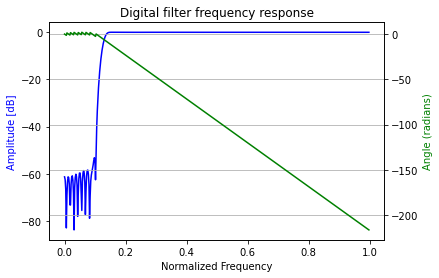

In [14]:
# firwin filter
# 155 taps, 3000Hz cutoff

numtaps = 155
f = hzNorm(3000)

firhp = signal.firwin(numtaps, f, pass_zero='highpass')

myFiltResponse(firhp, 1, sr)

### 3.1.1 Testing the FIR HiPass filter

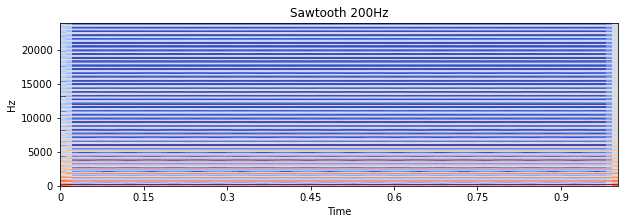

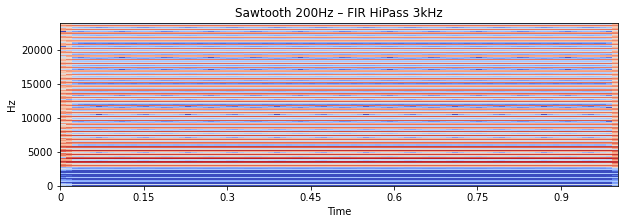

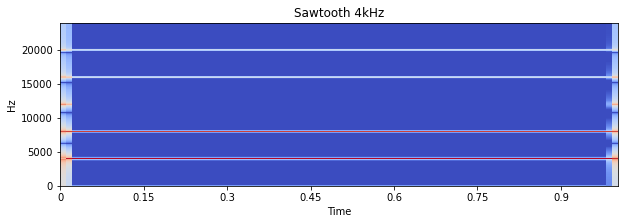

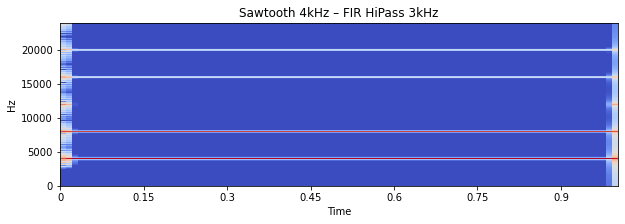

In [15]:
# Filtering the 200Hz sawtooth
firhp_saw200 = signal.lfilter(firhp, 1, saw200)
mySpectrogram(saw200, sr, 'Sawtooth 200Hz')
mySpectrogram(firhp_saw200, sr, 'Sawtooth 200Hz – FIR HiPass 3kHz')

# Filtering the 4kHz sawtooth
firhp_saw4000 = signal.lfilter(firhp, 1, saw4000)
mySpectrogram(saw4000, sr, 'Sawtooth 4kHz')
mySpectrogram(firhp_saw4000, sr, 'Sawtooth 4kHz – FIR HiPass 3kHz')

### 3.1.2 Playback of FIR filtered sawtooth
- You can clearly hear and see that there are a lot of harmonics in the 200Hz sawtooth. Even when filtered, you hear a lot of harmonics passing through.
- The 4kHz sawtooth are well above the cutoff point, and unchanged as expected.

In [16]:
sd.play(saw200/np.max(saw200),sr)
sd.wait()
sd.play(firhp_saw200/np.max(firhp_saw200),sr)
sd.wait()

sd.play(saw4000/np.max(saw4000),sr)
sd.wait()
sd.play(firhp_saw4000/np.max(firhp_saw4000),sr)
sd.wait()

### 3.2 Designing a High-Pass IIR filter

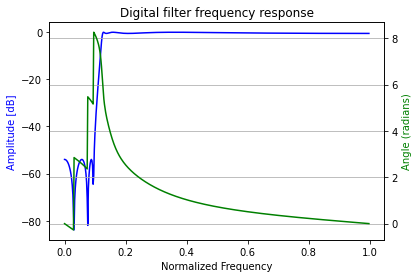

Number of taps: 7


In [17]:
# iirdesign filter
# 3000Hz cutoff, trying to tweak it similar to the FIR high-pass

wp = hzNorm(3000) # passband edge frequency
ws = hzNorm(2000) # stopband edge frewuency
gpass = 0.5 # maximum loss in the passband (dB)
gstop = 54 # minimum attenuation in the stopband (dB)

[iirhp_b, iirhp_a] = signal.iirdesign(wp, ws, gpass, gstop)

# displaying response
myFiltResponse(iirhp_b,iirhp_a,sr)

# printing number of taps
iirhp_taps = iirhp_b.size
print("Number of taps:", iirhp_taps)

### 3.2.1 Testing the IIR HiPass filter

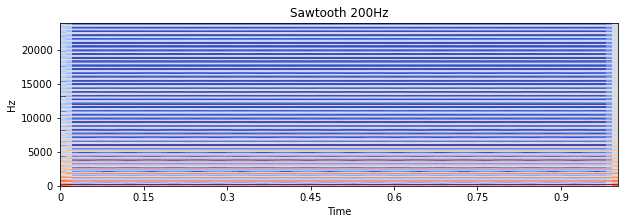

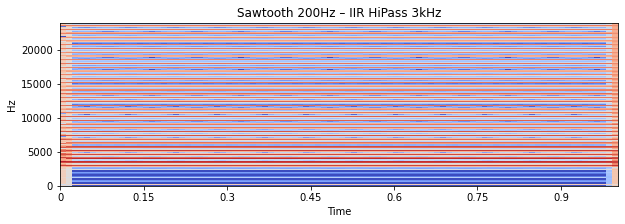

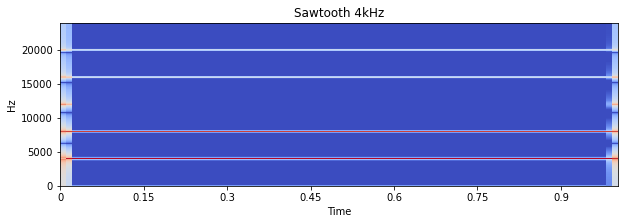

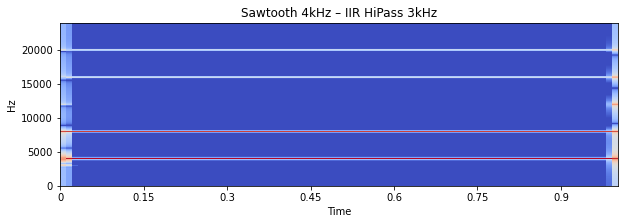

In [18]:
# Filtering the 200Hz sawtooth
iirhp_saw200 = signal.lfilter(iirhp_b, iirhp_a, saw200)
mySpectrogram(saw200, sr, 'Sawtooth 200Hz')
mySpectrogram(iirhp_saw200, sr, 'Sawtooth 200Hz – IIR HiPass 3kHz')

# Filtering the 4000Hz sawtooth
iirhp_saw4000 = signal.lfilter(iirhp_b, iirhp_a, saw4000)
mySpectrogram(saw4000, sr, 'Sawtooth 4kHz')
mySpectrogram(iirhp_saw4000, sr, 'Sawtooth 4kHz – IIR HiPass 3kHz')

### 3.2.2 Playback of IIR filtered sawtooth

- The filtered 200Hz signal sound and look like its FIR counterpart, with only 7 taps compared to 155.

In [19]:
sd.play(saw200/np.max(saw200),sr)
sd.wait()
sd.play(iirhp_saw200/np.max(iirhp_saw200),sr)
sd.wait()

sd.play(saw4000/np.max(saw4000),sr)
sd.wait()
sd.play(iirhp_saw4000/np.max(iirhp_saw4000),sr)
sd.wait()

### 3.3 Comparison
### 3.3.1 Average computation time

In [20]:
# Computing the average of 100 FIR computations
firhp_total = 0

for fir in range(num_times):
    start = time.time()
    firhp_time = signal.lfilter(firhp, 1, saw200)
    firhp_total += time.time() - start

firhp_mean = (firhp_total / num_times) * 1000


# Computing the average of 100 IIR computations
iirhp_total = 0

for iir in range(num_times):
    start = time.time()
    iirhp_time = signal.lfilter(iirhp_b, iirhp_a, saw200)
    iirhp_total += time.time() - start

iirhp_mean = (iirhp_total / num_times) * 1000


# Printing results
print("Average time pr filtering computation")
print("FIR High-Pass:\t{:.4f} ms".format(firhp_mean))
print("IIR High-Pass:\t{:.4f} ms".format(iirhp_mean))

Average time pr filtering computation
FIR High-Pass:	2.3256 ms
IIR High-Pass:	0.4775 ms


### 3.3.2 High-Pass Conclusion
The IIR filter is drastically faster in computation time, while still having quite similar result as the FIR filter. I notice that the while the IIR filter reaches the cutoff as instructed, the FIR filter seem to be a bit farther up in the frequencies before the passband are fully engaging. I've tried to counteract this by giving the FIR filter 155 taps, compared to the IIR's 7 taps.

---

## 4 Notch (Band Stop)

I will design two types of Notch filters with bandstop between 2kHz-4kHz

#### Generating Sinewaves for testing of filters

1 sec of 500Hz, 3kHz and 4kHz sinewaves

In [21]:
sin500 = mySineSynth(500, 1000, sr=sr)
sin3000 = mySineSynth(3000, 1000, sr=sr)
sin4100 = mySineSynth(4100, 1000, sr=sr)

### 4.1 Designing a Notch FIR filter

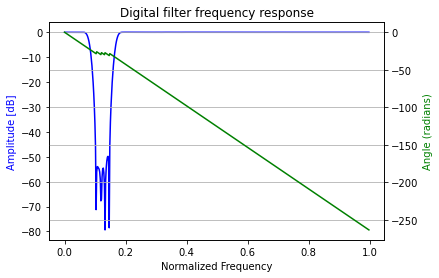

In [22]:
# firwin filter
# Notch between 2kHz-4kHz, 177 taps

f1, f2 = hzNorm(2000), hzNorm(4000)
numtaps = 177

firnotch = signal.firwin(numtaps, [f1, f2])

myFiltResponse(firnotch,1,sr)

### 4.1.1 Testing the FIR Notch filter

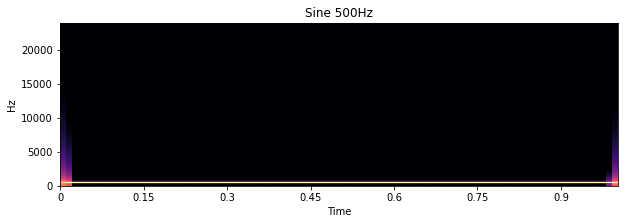

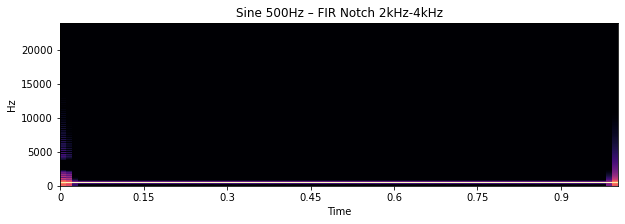

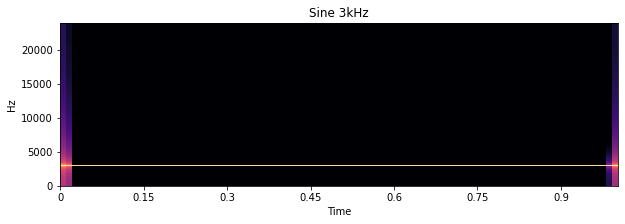

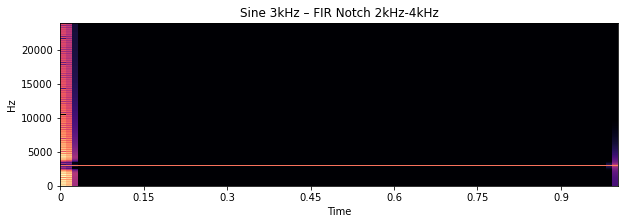

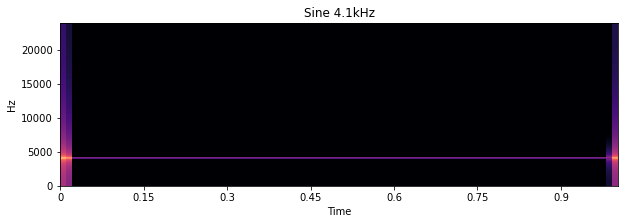

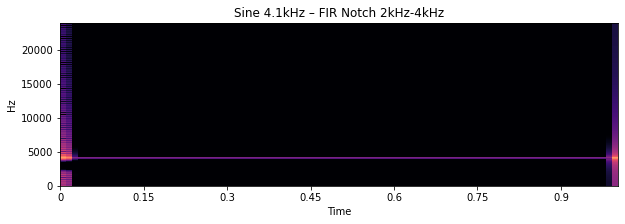

In [23]:
# Filtering the 500Hz sinewave
firnotch_sin500 = signal.lfilter(firnotch, 1, sin500)
mySpectrogram(sin500, sr, 'Sine 500Hz')
mySpectrogram(firnotch_sin500, sr, 'Sine 500Hz – FIR Notch 2kHz-4kHz')

# Filtering the 3kHz sinewave
firnotch_sin3000 = signal.lfilter(firnotch, 1, sin3000)
mySpectrogram(sin3000, sr, 'Sine 3kHz')
mySpectrogram(firnotch_sin3000, sr, 'Sine 3kHz – FIR Notch 2kHz-4kHz')

# Filtering the 4.1kHz sinewave
firnotch_sin4100 = signal.lfilter(firnotch, 1, sin4100)
mySpectrogram(sin4100, sr, 'Sine 4.1kHz')
mySpectrogram(firnotch_sin4100, sr, 'Sine 4.1kHz – FIR Notch 2kHz-4kHz')


### 4.1.2 Playback of FIR filtered sinewave
The sinewaves is without harmonics, and will thus remain unchanged in the passband and be heavily filtered in the stopband.
- We can hear the filtered 500Hz sinewave unchanged, as expected.
- The filtered 3kHz sinewave is heavily filtered, but we can still hear it.
- The filtered 4.1kHz sinewave sound and look unchanged.

In [24]:
sd.play(sin500/np.max(sin500),sr)
sd.wait()
sd.play(firnotch_sin500/np.max(firnotch_sin500),sr)
sd.wait()

sd.play(sin3000/np.max(sin3000),sr)
sd.wait()
sd.play(firnotch_sin3000/np.max(firnotch_sin3000),sr)
sd.wait()

sd.play(sin4100/np.max(sin4100),sr)
sd.wait()
sd.play(firnotch_sin4100/np.max(firnotch_sin4100),sr)
sd.wait()

### 4.2 Designing a Notch IIR filter

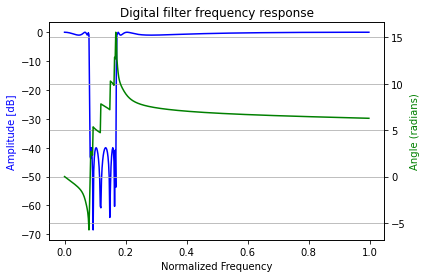

Number of taps: 15


In [25]:
# iirdesign filter (Cauer/elliptic)
# 2000Hz-4000Hz stopband, trying to tweak it similar to the FIR high-pass

n_wp = [hzNorm(1900), hzNorm(4100)] # passband edge frequency
n_ws = [hzNorm(2000), hzNorm(4000)] # stopband edge frequency
n_gpass = 1 # maximum loss in the passband (dB)
n_gstop = 40 # minimum attenuation in the stopband (dB)

[iirn_b, iirn_a] = signal.iirdesign(n_wp, n_ws, n_gpass, n_gstop)

# displaying response
myFiltResponse(iirn_b,iirn_a,sr)

# printing number of taps
iirn_taps = iirn_b.size
print("Number of taps:", iirn_taps)


### 4.2.1 Testing the Notch IIR filter

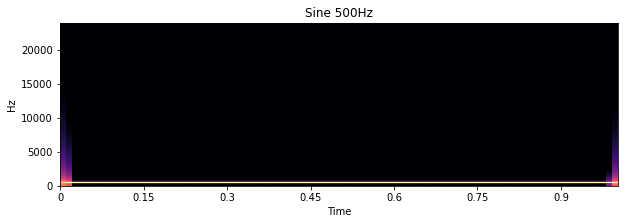

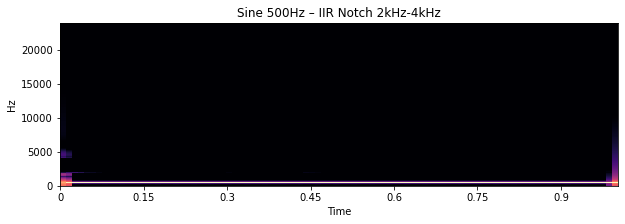

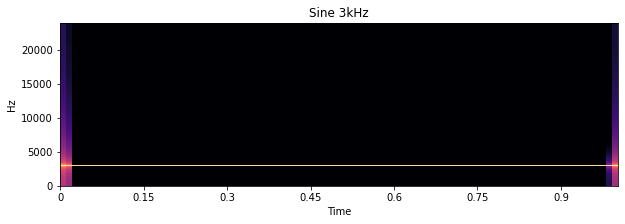

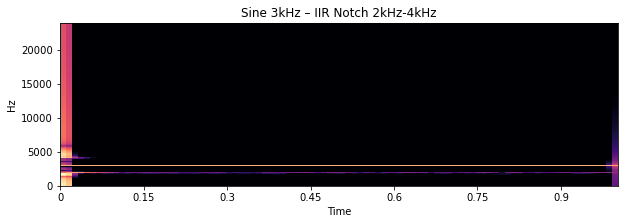

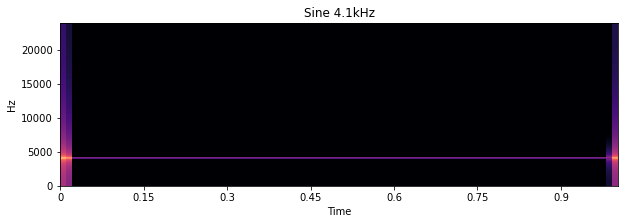

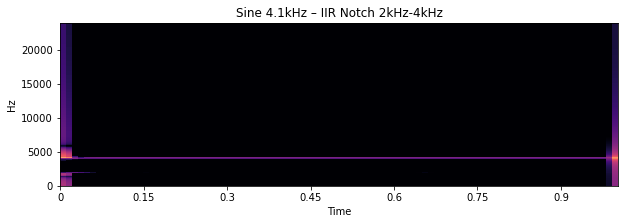

In [26]:
# Filtering the 500Hz sinewave
iirnotch_sin500 = signal.lfilter(iirn_b, iirn_a, sin500)
mySpectrogram(sin500, sr, 'Sine 500Hz')
mySpectrogram(iirnotch_sin500, sr, 'Sine 500Hz – IIR Notch 2kHz-4kHz')

# Filtering the 3kHz sinewave
iirnotch_sin3000 = signal.lfilter(iirn_b, iirn_a, sin3000)
mySpectrogram(sin3000, sr, 'Sine 3kHz')
mySpectrogram(iirnotch_sin3000, sr, 'Sine 3kHz – IIR Notch 2kHz-4kHz')

# Filtering the 4.1kHz sinewave
iirnotch_sin4100 = signal.lfilter(iirn_b, iirn_a, sin4100)
mySpectrogram(sin4100, sr, 'Sine 4.1kHz')
mySpectrogram(iirnotch_sin4100, sr, 'Sine 4.1kHz – IIR Notch 2kHz-4kHz')


### 4.2.2 Playback of IIR filtered sinewave
- The 3kHz sinewave is slightly less filtered with this IIR filter.
- The 4.1kHz sinewave also seems unfiltered in the IIR design, residing at the point where the transition band meets the passband. 

In [27]:
sd.play(sin500/np.max(sin500),sr)
sd.wait()
sd.play(iirnotch_sin500/np.max(iirnotch_sin500),sr)
sd.wait()

sd.play(sin3000/np.max(sin3000),sr)
sd.wait()
sd.play(iirnotch_sin3000/np.max(iirnotch_sin3000),sr)
sd.wait()

sd.play(sin4100/np.max(sin4100),sr)
sd.wait()
sd.play(iirnotch_sin4100/np.max(iirnotch_sin4100),sr)
sd.wait()

### 4.3 Comparison
### 4.3.1 Average computation time

In [28]:
# Computing the average of 100 FIR computations
firnotch_total = 0

for fir in range(num_times):
    start = time.time()
    firnotch_time = signal.lfilter(firnotch, 1, sin3000)
    firnotch_total += time.time() - start

firnotch_mean = (firnotch_total / num_times) * 1000


# Computing the average of 100 IIR computations
iirnotch_total = 0

for iir in range(num_times):
    start = time.time()
    iirnotch_time = signal.lfilter(iirn_b, iirn_a, sin3000)
    iirnotch_total += time.time() - start

iirnotch_mean = (iirnotch_total / num_times) * 1000


# Printing results
print("Average time pr filtering computation")
print("FIR Notch:\t{:.4f} ms".format(firnotch_mean))
print("IIR Notch:\t{:.4f} ms".format(iirnotch_mean))

Average time pr filtering computation
FIR Notch:	2.4483 ms
IIR Notch:	0.8677 ms


### 4.3.2 Conclusion
The IIR Notch filter is approximately 3-4 times faster than the FIR Notch filter, where it has 15 taps compared to the others 199 taps. The IIR filter looks also by far steeper with a very short transition band.

---

## 5 Band-Pass
I will design two types of Band-Pass filters with bandstop between 2kHz-4kHz, like inversions of the Notch filters.

#### Generating a chirp for testing of filters
1 sec of chirp from 1500Hz to 8kHz

In [29]:
# Generating a chirp
chirp = myChirp(1500,8000, 1, sr=sr)

### 5.1 Designing a Band-Pass FIR filter

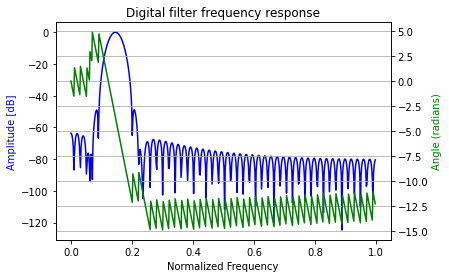

In [30]:
# firwin filter
# Band-pass between 3kHz-4kHz, 99 taps

f1, f2 = hzNorm(3000), hzNorm(4000)
numtaps = 99

firbp = signal.firwin(numtaps, [f1, f2], pass_zero='bandpass')

myFiltResponse(firbp,1,sr)

### 5.1.1 Testing the FIR Band-Pass filter

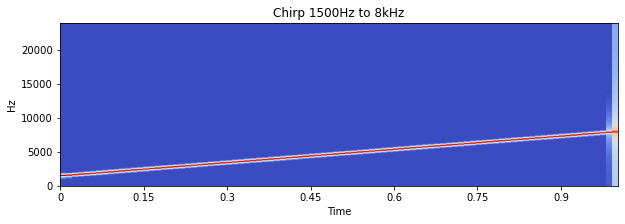

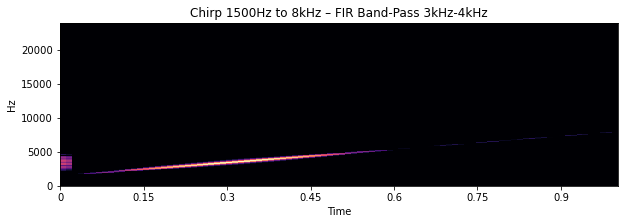

In [31]:
# Filtering the chirp
firbp_chirp = signal.lfilter(firbp, 1, chirp)
mySpectrogram(chirp, sr, 'Chirp 1500Hz to 8kHz')
mySpectrogram(firbp_chirp, sr, 'Chirp 1500Hz to 8kHz – FIR Band-Pass 3kHz-4kHz')

### 5.1.2 Playback of FIR filtered chirp
- We can hear a clean filtering of the chirp, fading in and out of the passband.
- It seems to be more filtered above, and less below, the bandpass area.

In [32]:
sd.play(chirp/np.max(chirp),sr)
sd.wait()
sd.play(firbp_chirp/np.max(firbp_chirp),sr)
sd.wait()

### 5.2 Designing a Band-Pass IIR filter
With slightly different cutoff frequencies than the FIR filter to try to make the filter responses more similar.

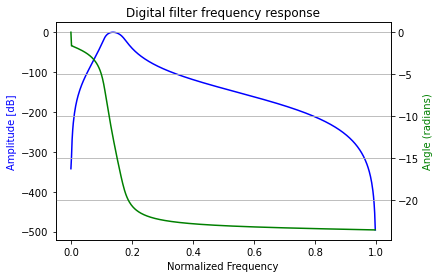

In [33]:
# bessel filter
# Band-pass between 2700Hz-4060Hz, 7 taps

f1, f2 = hzNorm(2700), hzNorm(4060)
numtaps = 7

bp_b, bp_a = signal.bessel(numtaps, [f1, f2], btype='bandpass')

myFiltResponse(bp_b,bp_a,sr)

### 5.2.1 Testing the IIR Band-Pass filter

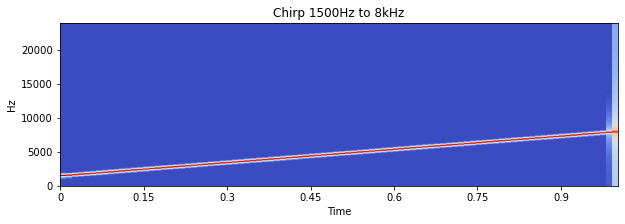

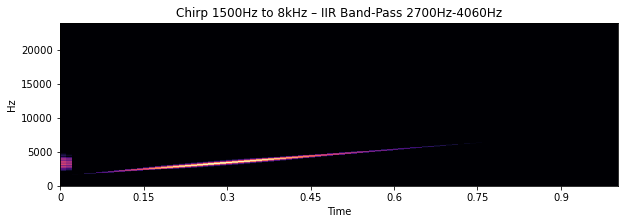

In [34]:
# Filtering the chirp
iirbp_chirp = signal.lfilter(bp_b, bp_a, chirp)
mySpectrogram(chirp, sr, 'Chirp 1500Hz to 8kHz')
mySpectrogram(iirbp_chirp, sr, 'Chirp 1500Hz to 8kHz – IIR Band-Pass 2700Hz-4060Hz')

### 5.2.2 Playback of IIR filtered chirp
- This FIR filter seemed to have a sweet spot on 99 taps. When I tried different amounts of less and more taps, it didn't filter that good outside of the bandpass.
- This IIR filter had a very narrow working area, in choosing amount of taps. I could only make 7-9 taps work, with 9 taps introducing a lot of undesired white noise. I also had to alter the cutoff points a bit from the FIR filter, to make the actual filter responses look and sound more alike.

In [35]:
sd.play(chirp/np.max(chirp),sr)
sd.wait()
sd.play(iirbp_chirp/np.max(iirbp_chirp),sr)
sd.wait()

### 5.3 Comparison
### 5.3.1 Average computation time

In [36]:
# Computing the average of 100 FIR computations
firbp_total = 0

for fir in range(num_times):
    start = time.time()
    firbp_time = signal.lfilter(firbp, 1, chirp)
    firbp_total += time.time() - start

firbp_mean = (firbp_total / num_times) * 1000


# Computing the average of 100 IIR computations
iirbp_total = 0

for iir in range(num_times):
    start = time.time()
    iirbp_time = signal.lfilter(bp_b, bp_a, chirp)
    iirbp_total += time.time() - start

iirbp_mean = (iirbp_total / num_times) * 1000


# Printing results
print("Average time pr filtering computation")
print("FIR Band-Pass:\t{:.4f} ms".format(firbp_mean))
print("IIR Band-Pass:\t{:.4f} ms".format(iirbp_mean))

Average time pr filtering computation
FIR Band-Pass:	2.6518 ms
IIR Band-Pass:	0.9125 ms


### 5.3.2 Conclusion
The Band-Pass filters took about the same as the other filter designs to compute, when reducing the chirp to a similar length as the other sound sources. The FIR filter took about 2-3 times longer than the IIR filter to compute, with its 99 taps versus IIR's 7 taps. The Band-Pass FIR did good compared to the other FIR filters, while the Band-Pass IIR did worse than the other IIR filters.

I think the FIR filter generally sounded better and was cleaner than the Bessel-type IIR filter, although I concealed this by tweaking the parameters of the IIR. To make the Band-Pass filter responses sound and look similar, I had to use different cutoff points for the IIR filter. I aimed to use the same frequency/cutoff values for each FIR/IIR pair of all the filters in this assignment, but I had to abandon that idea in order to make the Band-Pass filters sound alike.

---

## 6 Overview of Average Computation Time

In [37]:
print("FIR Low-Pass:\t{:.4f} ms".format(firlp_mean))
print("IIR Low-Pass:\t{:.4f} ms".format(iirlp_mean))
print()
print("FIR High-Pass:\t{:.4f} ms".format(firhp_mean))
print("IIR High-Pass:\t{:.4f} ms".format(iirhp_mean))
print()
print("FIR Notch:\t{:.4f} ms".format(firnotch_mean))
print("IIR Notch:\t{:.4f} ms".format(iirnotch_mean))
print()
print("FIR Band-Pass:\t{:.4f} ms".format(firbp_mean))
print("IIR Band-Pass:\t{:.4f} ms".format(iirbp_mean))

FIR Low-Pass:	2.0668 ms
IIR Low-Pass:	0.5322 ms

FIR High-Pass:	2.3256 ms
IIR High-Pass:	0.4775 ms

FIR Notch:	2.4483 ms
IIR Notch:	0.8677 ms

FIR Band-Pass:	2.6518 ms
IIR Band-Pass:	0.9125 ms


---

## 7.1 Challenges

The most challenging part for me this time was probably in advance of actually doing the assignment. To grasp the theory behind filtering, impulse responses and convolutions. Also I'd wish for more time available, a challenge in itself this time, so I could dive even deeper into the assignment and do more of the extras. It was also a bit tricky to decide how to do the layout and group the plottings and sound examples for comparison. To decipher the normalized frequencies from the plots were also a bit challenging.

## 7.2 Learnings

1) I learned and familiarized with parts of the Scipy library, a library which I'd not encounter before this assignment. It was nice to experiment with all the new waveforms available and test out different filter types – and then try to find suiting comboes.

2) I learned a lot of how filters actually work. I'm familiar with different filter types from the analog world and how they sound in synthesizers, and it was nice to see how they're made up in the digital domain. Also, even though I expected that the choice of frequencies for the waveforms would be important for demonstrating the filters properly, I learned that it isn't always easy to anticipate exactly how the frequency response will turn out around the transition band in the different filter designs.
